# Temat ćwiczenia: Sztuczne sieci neuronowe


# Import bibliotek

In [1]:
import pandas
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import time
import gc
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Wczytanie zbioru danych MNIST

In [2]:
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print("Rozmiar danych MNIST:", mnist.data.shape)
print("Rozmiar etykiet MNIST:", mnist.target.shape)

Rozmiar danych MNIST: (70000, 784)
Rozmiar etykiet MNIST: (70000,)


# Podział i obróbka zbioru danych

In [4]:
# One-Hot Encode
def encodiny(name, data, number):
  sample = np.zeros((len(data), number))
  print(f'{name} dataset shape: {sample.shape}')
  for i in range(0, len(data)):
    sample[i][data[i][0]] = 1
  return sample

In [5]:
training_data = mnist.data.to_numpy()
target_output = mnist.target.to_numpy()

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(training_data, target_output, test_size=0.3, random_state=42)

# Podział zbioru testowego na zbiór walidacyjny i testowy
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

# Obróbka danych
training_count = len(X_train[:, 0])
validation_count = len(X_val[:, 0])
test_count = len(X_test[:, 0])

y_train = y_train.reshape((-1, 1))
y_train = y_train.astype(int)
y_val = y_val.reshape((-1, 1))
y_val = y_val.astype(int)
y_test = y_test.reshape((-1, 1))
y_test = y_test.astype(int)

# Kodowanie danych
y_train = encodiny('Train', y_train, 10)
y_val = encodiny('Validation', y_val, 10)
y_test = encodiny('Test', y_test, 10)

Train dataset shape: (49000, 10)
Validation dataset shape: (8400, 10)
Test dataset shape: (12600, 10)


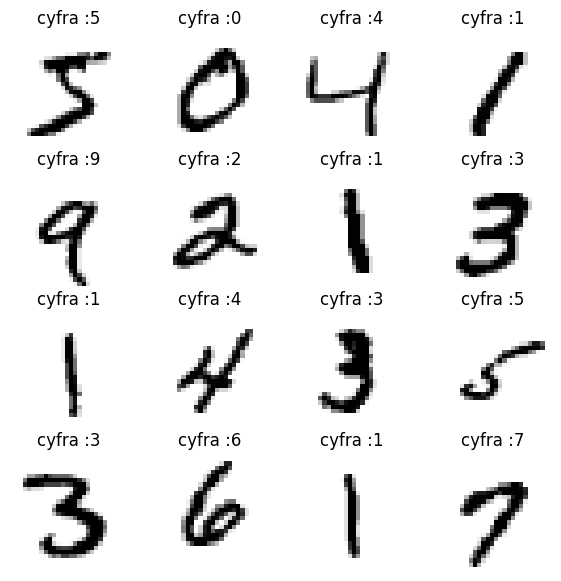

In [6]:
# Przykłądowe dane ze zbioru
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title("cyfra :" + str(target_output[i]))
    plt.axis('off')
    plt.imshow(training_data[i].reshape(28, 28), cmap='gray_r')

# Funkcje aktywacji

**Sigmoidalna**

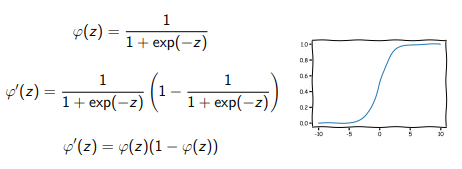


**Softmax**

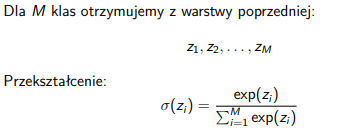

In [7]:
class ActivationFunctions:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_derivative(x):
        sigmoid_x = ActivationFunctions.sigmoid(x)
        return sigmoid_x * (1 - sigmoid_x)

    @staticmethod
    def softmax(x):
        x = x - np.max(x, axis=1, keepdims=True)
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


# Perceptron wielowarstwowy

**Propagacja wprzód**

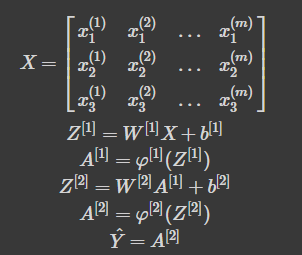

**Propagacja wstecz**

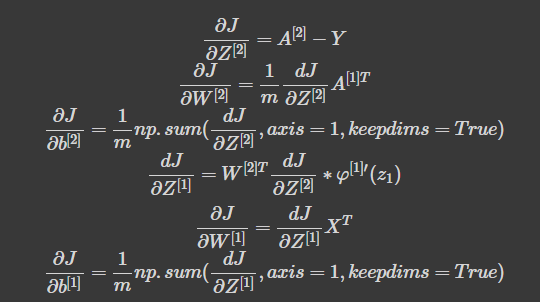

In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, logs, plot):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        seed_value = 33
        np.random.seed(seed_value)
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)

        self.biases1 = np.zeros((1, self.hidden_size))
        self.biases2 = np.zeros((1, self.output_size))

        self.logs = logs
        self.plot = plot

    # Propagacja w przód
    def forward(self, X):
        self.s1 = np.dot(X, self.weights1) + self.biases1
        self.y1 = ActivationFunctions.sigmoid(self.s1)
        self.s2 = np.dot(self.y1, self.weights2) + self.biases2
        self.y2 = ActivationFunctions.softmax(self.s2)
        return self.y2

    # Propagacja wstecz
    def backpropagation(self, X, y, learning_rate):
        m = X.shape[0]

        # Warstwa wyjściowa
        error_output = (self.y2 - y) / m
        d_biases2 = np.sum(error_output, axis=0, keepdims=True)
        d_weights2 = np.dot(self.y1.T, error_output)

        # Warstwa ukryta
        error_hidden = np.dot(error_output, self.weights2.T) * ActivationFunctions.sigmoid_derivative(self.y1)
        d_biases1 = np.sum(error_hidden, axis=0)
        d_weights1 = np.dot(X.T, error_hidden)

        # Aktualizacja wag i biasu
        self.weights2 -= learning_rate * d_weights2
        self.biases2 -= learning_rate * d_biases2
        self.weights1 -= learning_rate * d_weights1
        self.biases1 -= learning_rate * d_biases1

    # Wizualizacja zmiany wartości dokładnosci i straty na zbiorze treningowym i validacyjnym
    def plot_loss_accuracy(self, train_losses, train_accuracies, val_losses, val_accuracies, epochs):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train', color='blue')
        plt.plot(epochs, val_losses, label='Validation', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train', color='blue')
        plt.plot(epochs, val_accuracies, label='Validation', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

    # Trening preceptronu
    def train(self, X_train, y_train, X_val, y_val, learning_rate, epochs):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.epochss = []

        for epoch in range(epochs):
            output = self.forward(X_train)
            self.backpropagation(X_train, y_train, learning_rate)

            if (epoch + 1)/epochs*100 % 2 == 0:
                train_loss = np.mean(np.square(output - y_train))
                train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(output, axis=1))

                val_output = self.forward(X_val)
                val_loss = np.mean(np.square(val_output - y_val))
                val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))

                self.train_losses.append(train_loss)
                self.train_accuracies.append(train_accuracy)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_accuracy)
                self.epochss.append(epoch)

                if self.logs == True:
                  print(f"Epoch {epoch + 1}/{epochs},  {(epoch+1)/epochs*100}%,  Train Loss: {train_loss},  Train Accuracy: {train_accuracy},  Val Loss: {val_loss},  Val Accuracy: {val_accuracy}")

        if self.plot == True:
          self.plot_loss_accuracy(self.train_losses, self.train_accuracies, self.val_losses, self.val_accuracies, self.epochss)

        return self.train_losses, self.train_accuracies, self.val_losses, self.val_accuracies

# Walidacja

## Znalezienie optymalnego wzmocnienia algorytmu uczenia

In [9]:
time_result = []
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []
steps = []
iter = 1
for step in np.arange(0.1, 2.1, 0.1):
  steps.append(step)
  print("Trenowanie nr. " + str(iter))
  iter += 1

  # Inicjalzacja klasy NeuralNetwork
  nn = NeuralNetwork(784, 20, 10, logs=False, plot=False)

  # Trening perceprtonu
  gc_old = gc.isenabled() # pobierz aktualny stan odśmiecania
  gc.disable() # wyłącz odśmiecanie
  start = time.process_time() # pobierz aktualny czas - start zegara

  nn.train(X_train, y_train, X_val, y_val, step, 200)
  train_accuracy.append(nn.train_accuracies[-1])
  train_loss.append(nn.train_losses[-1])
  val_accuracy.append(nn.val_accuracies[-1])
  val_loss.append(nn.val_losses[-1])

  stop= time.process_time()  # zatrzymanie zegara
  if gc_old: gc.enable()  # przywróć pierwotny stan odśmiecania

  time_result.append(stop - start)

Trenowanie nr. 1
Trenowanie nr. 2
Trenowanie nr. 3
Trenowanie nr. 4
Trenowanie nr. 5
Trenowanie nr. 6
Trenowanie nr. 7
Trenowanie nr. 8
Trenowanie nr. 9
Trenowanie nr. 10
Trenowanie nr. 11
Trenowanie nr. 12
Trenowanie nr. 13
Trenowanie nr. 14
Trenowanie nr. 15
Trenowanie nr. 16
Trenowanie nr. 17
Trenowanie nr. 18
Trenowanie nr. 19
Trenowanie nr. 20


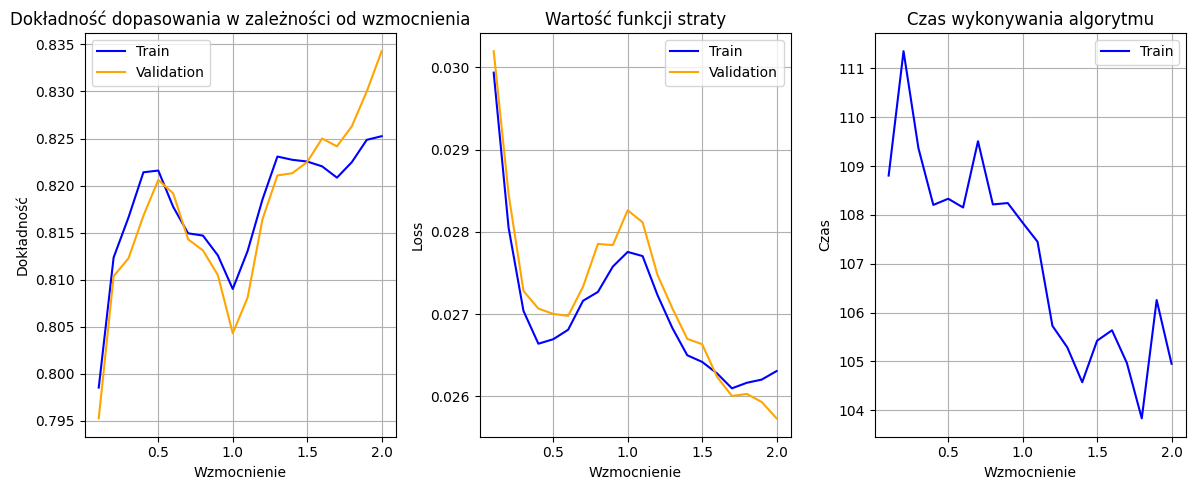

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(steps, train_accuracy, label='Train', color='blue')
plt.plot(steps, val_accuracy, label='Validation', color='orange')
plt.xlabel('Wzmocnienie')
plt.ylabel('Dokładność')
plt.title('Dokładność dopasowania w zależności od wzmocnienia')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(steps, train_loss, label='Train', color='blue')
plt.plot(steps, val_loss, label='Validation', color='orange')
plt.xlabel('Wzmocnienie')
plt.ylabel('Loss')
plt.title('Wartość funkcji straty')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(steps, time_result, label='Train', color='blue')
plt.xlabel('Wzmocnienie')
plt.ylabel('Czas')
plt.title('Czas wykonywania algorytmu')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Wnioski

Na podstawie przeprowadzonych testów i analizy otrzymanych wykresów możemy stwierdzić, że najlepszą dokłądność, przy najniższej wartości funkcji straty i optymalnym czasie potrzebnym na wykonanie algorytmu otrzymujemy dla wartości współczynnika kroku (learning_rate) równej około 0.7. Wartość tą będziemy wykorzystywać w dalszej części projektu.

## Liczba warstw wewnętrznych

In [11]:
time_result = []
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []
layers_list = []
iter = 1
for layers in np.arange(10, 51, 4):
  layers_list.append(layers)
  print("Trenowanie nr. " + str(iter))
  iter += 1

  # Inicjalzacja klasy NeuralNetwork
  nn = NeuralNetwork(784, layers, 10, logs=False, plot=False)

  # Trening perceprtonu
  gc_old = gc.isenabled() # pobierz aktualny stan odśmiecania
  gc.disable() # wyłącz odśmiecanie
  start = time.process_time() # pobierz aktualny czas - start zegara

  nn.train(X_train, y_train, X_val, y_val, 0.7, 200)
  train_accuracy.append(nn.train_accuracies[-1])
  train_loss.append(nn.train_losses[-1])
  val_accuracy.append(nn.val_accuracies[-1])
  val_loss.append(nn.val_losses[-1])

  stop= time.process_time()  # zatrzymanie zegara
  if gc_old: gc.enable()  # przywróć pierwotny stan odśmiecania

  time_result.append(stop - start)

Trenowanie nr. 1
Trenowanie nr. 2
Trenowanie nr. 3
Trenowanie nr. 4
Trenowanie nr. 5
Trenowanie nr. 6
Trenowanie nr. 7
Trenowanie nr. 8
Trenowanie nr. 9
Trenowanie nr. 10
Trenowanie nr. 11


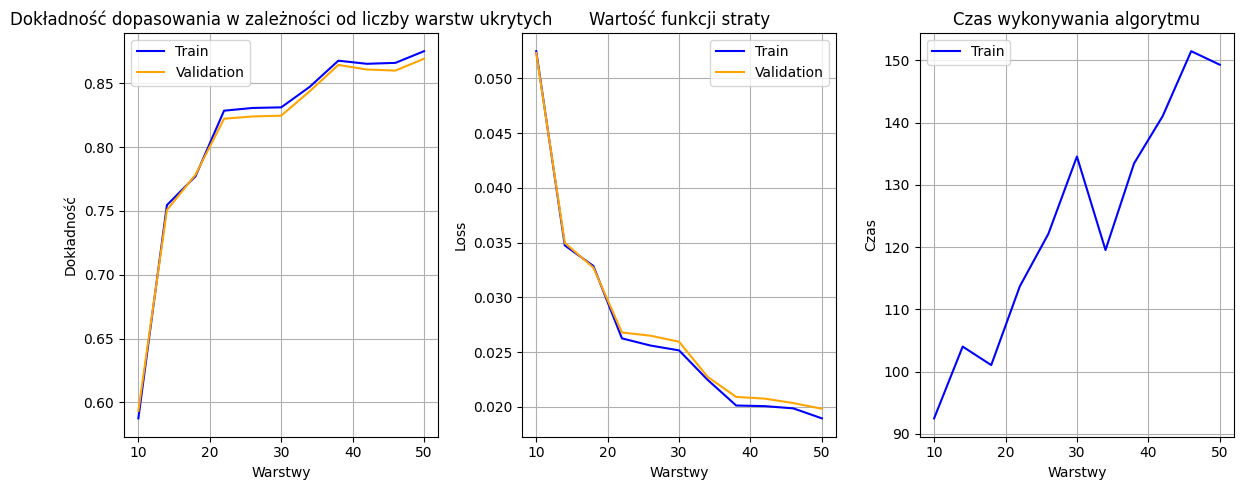

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(layers_list, train_accuracy, label='Train', color='blue')
plt.plot(layers_list, val_accuracy, label='Validation', color='orange')
plt.xlabel('Warstwy')
plt.ylabel('Dokładność')
plt.title('Dokładność dopasowania w zależności od liczby warstw ukrytych')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(layers_list, train_loss, label='Train', color='blue')
plt.plot(layers_list, val_loss, label='Validation', color='orange')
plt.xlabel('Warstwy')
plt.ylabel('Loss')
plt.title('Wartość funkcji straty')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(layers_list, time_result, label='Train', color='blue')
plt.xlabel('Warstwy')
plt.ylabel('Czas')
plt.title('Czas wykonywania algorytmu')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Trenowanie

Epoch 100/5000,  2.0%,  Train Loss: 0.02044804070603559,  Train Accuracy: 0.864,  Val Loss: 0.020476936738732066,  Val Accuracy: 0.8610714285714286
Epoch 200/5000,  4.0%,  Train Loss: 0.018187760775877592,  Train Accuracy: 0.8786938775510205,  Val Loss: 0.01844629240851869,  Val Accuracy: 0.8763095238095238
Epoch 300/5000,  6.0%,  Train Loss: 0.017149981183684302,  Train Accuracy: 0.8848775510204082,  Val Loss: 0.017762985082846388,  Val Accuracy: 0.8820238095238095
Epoch 400/5000,  8.0%,  Train Loss: 0.017026841754788323,  Train Accuracy: 0.8863469387755102,  Val Loss: 0.017380480028159485,  Val Accuracy: 0.8857142857142857
Epoch 500/5000,  10.0%,  Train Loss: 0.017248902159850737,  Train Accuracy: 0.884061224489796,  Val Loss: 0.017542679591084083,  Val Accuracy: 0.8817857142857143
Epoch 600/5000,  12.0%,  Train Loss: 0.01734425436015709,  Train Accuracy: 0.8831224489795918,  Val Loss: 0.017450511250280507,  Val Accuracy: 0.8828571428571429
Epoch 800/5000,  16.0%,  Train Loss: 0.0169

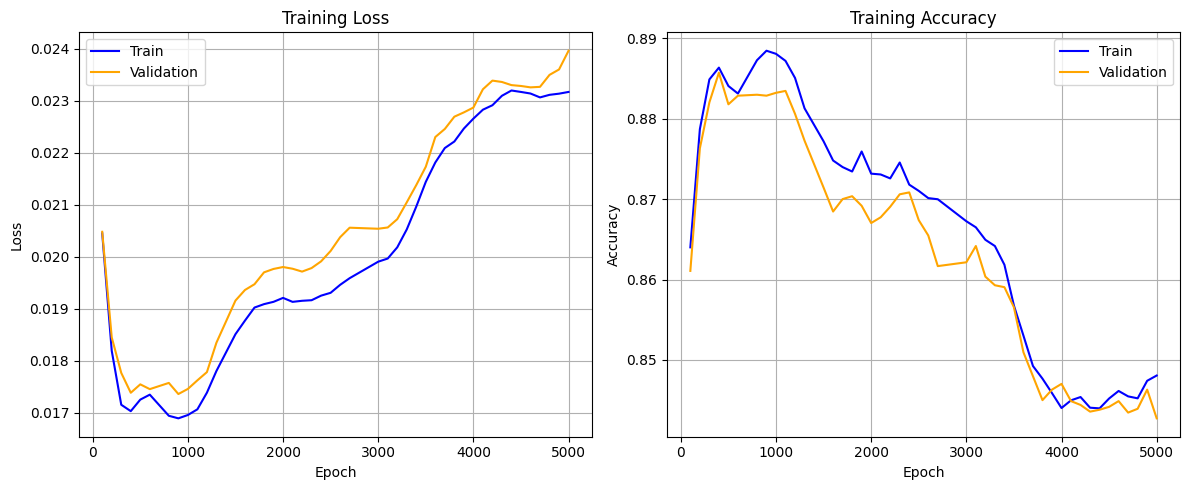

In [13]:
from numpy.random.mtrand import standard_t
# Inicjalzacja klasy NeuralNetwork
net = 0
net = NeuralNetwork(784, 60, 10, logs=True, plot=True)

# Trening perceprtonu
gc_old = gc.isenabled() # pobierz aktualny stan odśmiecania
gc.disable() # wyłącz odśmiecanie
start = time.process_time() # pobierz aktualny czas - start zegara

train_l, train_acc, val_l, val_acc = net.train(X_train, y_train, X_val, y_val, 0.7, 5000)

stop= time.process_time()  # zatrzymanie zegara
if gc_old: gc.enable()  # przywróć pierwotny stan odśmiecania
czas = stop - start

In [14]:
# Otrzymane wyniki
print(f"Train Loss: {round(train_l[-1], 4)}, Train Accuracy: {round(train_acc[-1],4)}")
print(f"Val Loss: {round(val_l[-1],4)}, Val Accuracy: {round(val_acc[-1],4)}")
print(f"Czas treningu: {round(czas,2)} sekund")

Train Loss: 0.0232, Train Accuracy: 0.8481
Val Loss: 0.024, Val Accuracy: 0.8427
Czas treningu: 4211.5 sekund


# Predykcja wyników na zbiorze testowym

In [15]:
# Dokonywanie predykcji na zbiorze testowym
y_pred = net.forward(X_test)
predicted_labels = np.argmax(y_pred, axis=1)

# Wyświetlanie wyników predykcji
print("Predicted labels for test samples:")
print(predicted_labels)

# Obliczanie dokładności predykcji
accuracy = np.mean(predicted_labels == np.argmax(y_test, axis=1))
print("Accuracy:", round(accuracy,4))

Predicted labels for test samples:
[4 4 7 ... 4 2 8]
Accuracy: 0.8477


# Wnioski

1. Przy odpowiednio małej wartości learning_rate uzyskujemy spadek funcji straty w kolejnych iteracjach. Co wiecej im mniejsza wartości learning_rate, tym dłuższy czas uczenia sieci, ale zarazem większa dokładność. Przy dużych wartościach współczynnika learning_rate mamy do czynienia z mniejszą dokładnością otrzymanych wyników, ale sam proces trenowania sieci trwa krócej. Jednak przy zbyt dużej wartości learning_rate może dość do oddalania się od poszukiwanego minimum, przez co sieć nie uczy się poprawnie.

2. Wagi i bias dobierane są w sposób losowy, stąd też otrzymane wartości dokładności i straty na zbiorach różnią się nieznacznie miedzy sobą. Poniżej zestawiono średnie wyniki z 25 pomiarów dla różnej ilości epok oraz przykłądowe otrzymane wykresy.


**Dla wartości epok = 10**

Train Loss: 0.0863, Train Accuracy: 0.4143

Val Loss: 0.0638, Val Accuracy: 0.5813

Czas treningu: 10.39 sekund

Test Accuracy: 0.5865

Przykładowe wykresy:

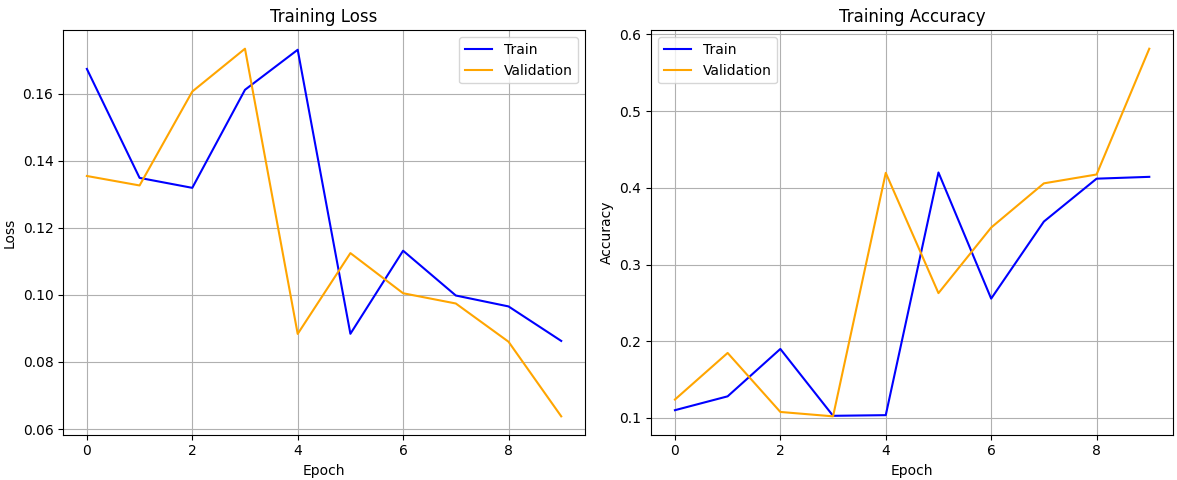

**Dla wartości epok = 100**

Train Loss: 0.0204, Train Accuracy: 0.864

Val Loss: 0.0205, Val Accuracy: 0.8611

Czas treningu: 92.88 sekund

Test Accuracy: 0.8587

Przykładowe wykresy:

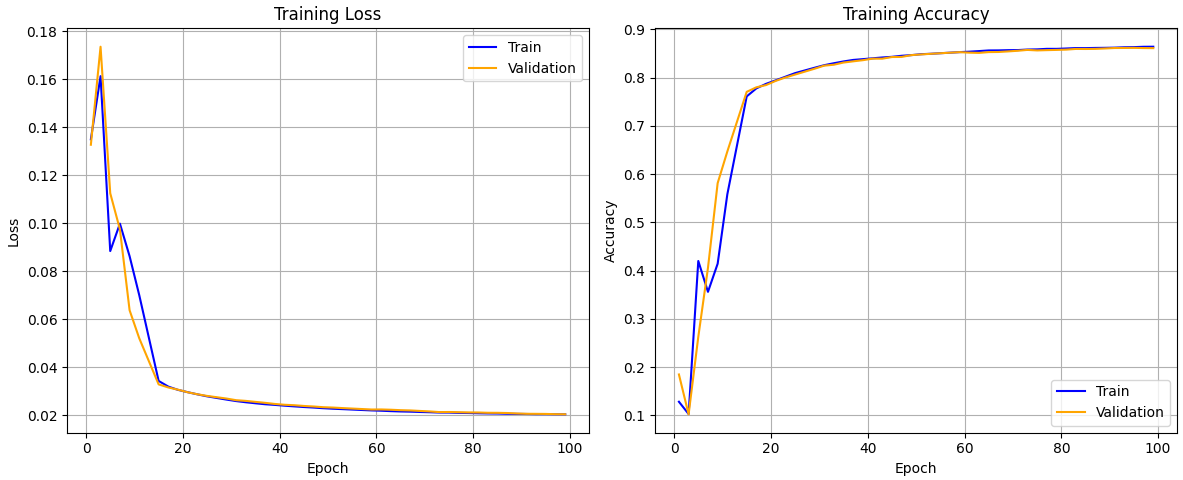

**Dla wartości epok = 500**

Train Loss: 0.0173, Train Accuracy: 0.884

Val Loss: 0.0175, Val Accuracy: 0.8818

Czas treningu: 579.9395784219996 sekund

Test Accuracy: 0.8823

Przykładowe wykresy:


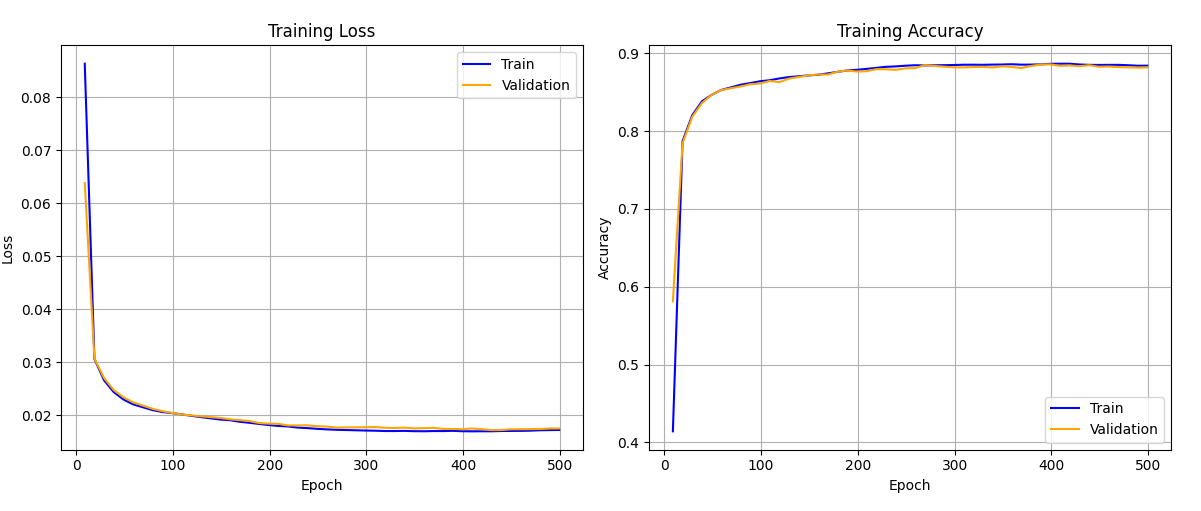


**Dla wartości epok = 1000**

Train Loss: 0.017, Train Accuracy: 0.8881

Val Loss: 0.0175, Val Accuracy: 0.8832

Czas treningu: 876.18 sekund

Test Accuracy: 0.8856

Przykładowe wykresy:

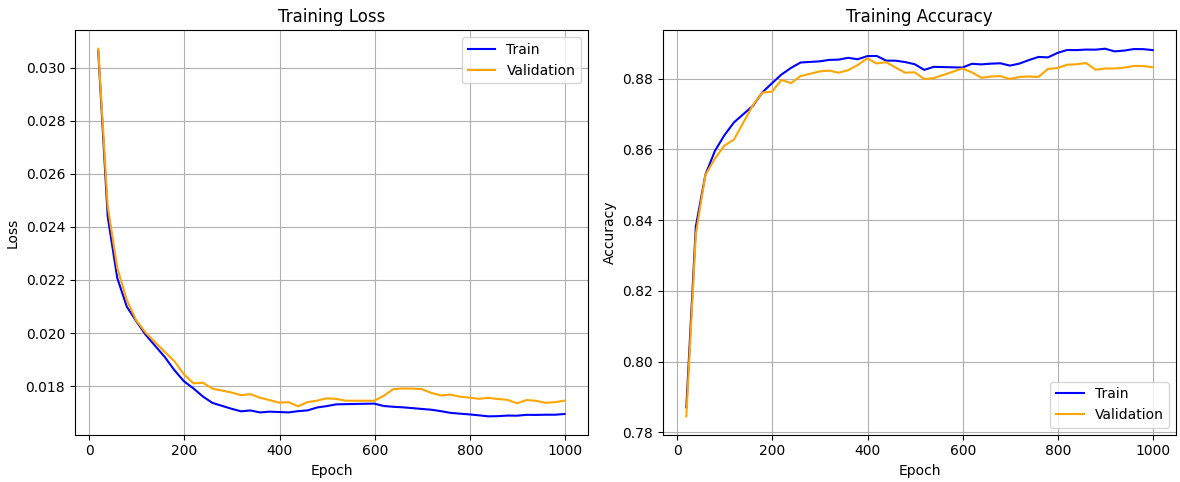



Widać, że wraz ze wzrostem liczby epok wzrastała dokładość na zbiorach, jednak wiązało się to również ze znacznym wzrostem czasu potrzebnym na trening sieci. Przy większej ilości epok dobrym rozwiazaniem może okazać się zwiększenie wartości współczynnika learning rate odpowiedzialnego za szybkość zbiegania do minimum funkcji straty (algorytm optymalizacji gradientowej), zabieg ten może przyspieszyć działanie sieci, jednak kosztem jego dokładności.

Optymalna liczba epok dająca dobre wyniki, przy nizbyt długim czasie nauki mieści się w przedziale od 100 do 500, gdzie dokładność na zbiorze testowym wyniosła 0.8587 - 0.8823.

Powyżej 500 epok nie odnotowano znacznego wzrostu dokładności na zbiorze testowym, zaś wydłużył się czas uczenia (już w  przypadku 1000 epok prawie dwukrotnie).



3. Dokładność na zbiorze testowym w przedziale 0.85-0.88 pozwala stwierdzić, że percepron radzi sobie całkiem nieźle w klasyfikacji danych ze zbioru MNIST.

4. Widać dużą zależność końcowych wyników od wylosowanych wartości wag początkowych. W zależności od ich układu model może trenować się szybciej lub wolniej a także może w różnym stopniu dochodzić do nadmiernego dopasowania.